# Install packages

In [1]:
!git clone https://github.com/montemac/algebraic_value_editing.git
!cd algebraic_value_editing && pip install -e .
#!pip install sentence_transformers umap-learn hdbscan

import sys
sys.path.insert(0,"/content/algebraic_value_editing")
from typing import List, Dict, Callable, Literal
from transformer_lens.HookedTransformer import HookedTransformer
from tuned_lens import TunedLens
from tuned_lens.plotting import PredictionTrajectory
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import joblib
import requests
import json
from collections import Counter
import itertools
from algebraic_value_editing import completion_utils, utils
from algebraic_value_editing.prompt_utils import get_x_vector
from algebraic_value_editing.lenses import run_hooked_and_normal_with_cache, prediction_trajectories
import algebraic_value_editing.hook_utils as hook_utils
from plotly.subplots import make_subplots
from transformers import AutoModelForCausalLM
from transformer_lens.utils import to_numpy
from einops import rearrange
from google.colab import drive
drive.mount('/content/drive')

fatal: destination path 'algebraic_value_editing' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/algebraic_value_editing
  Preparing metadata (setup.py) ... done
  Using cached transformer_lens-0.0.0-py3-none-any.whl
  Attempting uninstall: algebraic-value-editing
    Found existing installation: algebraic-value-editing 0.2.0
    Uninstalling algebraic-value-editing-0.2.0:
      Successfully uninstalled algebraic-value-editing-0.2.0
  Running setup.py develop for algebraic-value-editing
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Set up functions

In [2]:
def fwd_hooks_from_activ_hooks(activ_hooks):
    """
    Because AVE data structures differ from transformerlens we must convert.
    >>> fwd_hooks_from_activ_hooks({'blocks.47.hook_resid_pre': ['e1', 'e2']]})
    [('blocks.47.hook_resid_pre', 'e1'), ('blocks.47.hook_resid_pre', 'e2')]
    """
    return [
        (name, hook_fn)
        for name, hook_fns in activ_hooks.items()
        for hook_fn in hook_fns
    ]

def run_hooked_and_normal_with_cache_mlp(
    model, activation_additions, gen_args, device=None
):
    """
    Run hooked and normal with cache.

    Args:
        model: The model to run.
        activation_additions: A list of ActivationAdditions.
        gen_args: Keyword arguments to pass to `completion_utils.gen_using_model`.
            Must include `prompt_batch` and `tokens_to_generate`.

    Returns:
        normal_and_modified_df: A list of two dataframes, one for normal and one for modified.
        normal_and_modified_cache: A list of two caches, one for normal and one for modified.
    """
    assert (
        len(gen_args.get("prompt_batch", [])) == 1
    ), f'Only one prompt is supported. Got {len(gen_args.get("prompt_batch", []))}'

    activ_hooks = hook_utils.hook_fns_from_activation_additions(
        model, activation_additions
    )
    fwd_hooks = fwd_hooks_from_activ_hooks(activ_hooks)
    normal_and_modified_df = []
    normal_and_modified_cache = []

    for fwd_hooks, is_modified in [([], False), (fwd_hooks, True)]:
        cache, caching_hooks, _ = model.get_caching_hooks(
            names_filter=lambda n: "mlp.hook_post" in n, device=device
        )

        # IMPORTANT: We call caching hooks *after* the value editing hooks.
        with model.hooks(fwd_hooks=fwd_hooks + caching_hooks):
            results_df = completion_utils.gen_using_model(
                model, include_logits=True, **gen_args
            )
            results_df["is_modified"] = is_modified
        normal_and_modified_df.append(results_df)
        normal_and_modified_cache.append(cache)

    return normal_and_modified_df, normal_and_modified_cache

def get_cache_diff(caches, prompt_only=False, prompt=None, model=None):
    n_layers = len(caches[0].keys())
    d_mlp = caches[0]['blocks.0.mlp.hook_post'].shape[2]
    activation_shape = (n_layers, d_mlp)
    activations = np.zeros(activation_shape)
    if not prompt_only:
        for layer in range(n_layers):
            cache_diff = np.average(to_numpy(caches[1][f'blocks.{layer}.mlp.hook_post'])[0,:,:], axis=0) - \
                np.average(to_numpy(caches[0][f'blocks.{layer}.mlp.hook_post'])[0,:,:], axis=0)
            activations[layer, :] = cache_diff
    else:
        prompt_len = len(model.to_str_tokens(prompt))
        for layer in range(n_layers):
            cache_diff = np.average(to_numpy(caches[1][f'blocks.{layer}.mlp.hook_post'])[0,0:prompt_len,:], axis=0) - \
                np.average(to_numpy(caches[0][f'blocks.{layer}.mlp.hook_post'])[0,0:prompt_len,:], axis=0)
            activations[layer, :] = cache_diff
    return activations

def get_activation_diff_iterations(
    prompt,
    activation_additions,
    N_iterations=100,
    tokens_to_generate=30,
    prompt_only=False
    ):
    N_iterations = N_iterations
    n_layers = 48
    d_mlp = 6400
    activation_diff_iterations_shape = (N_iterations, n_layers, d_mlp)
    activation_diff_iterations = np.zeros(activation_diff_iterations_shape)

    for n in range(N_iterations):
        dataframes, caches = run_hooked_and_normal_with_cache_mlp(
            model = model,
            activation_additions = activation_additions,
            gen_args = dict(
                prompt_batch=[prompt] * 1,
                tokens_to_generate=50,
                top_p=0.3,
                temperature=1.0,
                freq_penalty=1.0,
                seed=n
            )
        )
        activation_diff = get_cache_diff(caches, prompt_only=prompt_only,
                                         prompt=prompt, model=model)
        activation_diff_iterations[n,:,:] = activation_diff
    return activation_diff_iterations


def get_activation_diff_end_of_prompt_iterations(
    prompt,
    activation_additions,
    N_iterations=100,
    tokens_to_generate=10,
    prompt_only=False
    ):
    N_iterations = N_iterations
    n_layers = 48
    d_mlp = 6400
    activation_diff_iterations_shape = (N_iterations, n_layers, d_mlp)
    activation_diff_iterations = np.zeros(activation_diff_iterations_shape)
    prompt_len = len(model.to_str_tokens(prompt))

    for n in range(N_iterations):
        dataframes, caches = run_hooked_and_normal_with_cache_mlp(
            model = model,
            activation_additions = activation_additions,
            gen_args = dict(
                prompt_batch=[prompt] * 1,
                tokens_to_generate=tokens_to_generate,
                top_p=0.3,
                temperature=1.0,
                freq_penalty=1.0,
                seed=n
            )
        )
        activation_diff_over_tokens = get_cache_diff_over_tokens(caches,
                                                                 prompt_only = False)
        activation_diff_iterations[n,:,:] = activation_diff_over_tokens[prompt_len,:,:]
    return activation_diff_iterations

def get_activation_diff_top_index_list(
    activation_diff_iterations,
    top_percentage = 0.01):
    top_percentage = top_percentage
    index_size = activation_diff_iterations[0,:,:].size
    top_size = int(index_size * top_percentage)
    num_activation_diff = activation_diff_iterations.shape[0]
    top_index_list = []
    for i in range(num_activation_diff):
        top_indices = np.dstack(np.unravel_index(np.argsort(activation_diff_iterations[i,:,:], axis=None)[::-1], activation_diff_iterations[0,:,:].shape))[0,0:top_size,:]
        top_index_tuples = list(map(tuple, top_indices))
        top_index_list.append(top_index_tuples)
    return top_index_list

def load_openai_explanations(neuron_index_tuple):
    layer_index = neuron_index_tuple[0]
    neuron_index = neuron_index_tuple[1]
    url = "https://openaipublic.blob.core.windows.net/neuron-explainer/data/explanations/{}/{}.jsonl".format(layer_index, neuron_index)
    # Send an HTTP GET request to the URL
    response = requests.get(url)
    neuron_explanations = json.loads(response.content)
    neuron_explanations = neuron_explanations['scored_explanations'][0]['explanation']
    return neuron_explanations

def print_openai_explanaions(activation_diff_over_tokens,
                             top_percentage = 0.005,
                             print_size = 20):
    top_index_list = get_activation_diff_top_index_list(
        activation_diff_over_tokens,
        top_percentage = top_percentage)
    counter = Counter(list(itertools.chain.from_iterable(top_index_list)))
    for i in range(print_size):
        print("neuron_id: {}, count: {}, explanations: {}".format(
            counter.most_common()[i][0],
            counter.most_common()[i][1],
            load_openai_explanations(counter.most_common()[i][0])
        ))

def lambda_max(arr, axis=None, key=None, keepdims=False):
    if callable(key):
        idxs = np.argmax(key(arr), axis)
        if axis is not None:
            idxs = np.expand_dims(idxs, axis)
            result = np.take_along_axis(arr, idxs, axis)
            if not keepdims:
                result = np.squeeze(result, axis=axis)
            return result
        else:
            return arr.flatten()[idxs]
    else:
        return np.amax(arr, axis)


def print_openai_explanaions_from_ordered_index(
    activation_diff_ordered_index,
    print_size = 20):
    print("------ Top positive related neurons ------")
    for i in range(print_size):
        neuron_index = (activation_diff_ordered_index[i][0],
                        activation_diff_ordered_index[i][1])
        print("neuron_id: {}, explanations: {}".format(
            neuron_index,
            load_openai_explanations(neuron_index)
        ))
    print("------ Top negative related neurons ------")
    for i in range(print_size):
        neuron_index = (activation_diff_ordered_index[-i-1][0],
                        activation_diff_ordered_index[-i-1][1])
        print("neuron_id: {}, explanations: {}".format(
            neuron_index,
            load_openai_explanations(neuron_index)
        ))

def store_openai_explanaions_from_ordered_index(
    activation_diff_ordered_index,
    neuron_store_size = 100):
    neuron_explanations = {"positive": {"ids": [],
                                        "explanations": []},
                           "negative": {"ids": [],
                                        "explanations": []}
                           }
    for i in range(neuron_store_size):
        neuron_index = (activation_diff_ordered_index[i][0],
                        activation_diff_ordered_index[i][1])
        neuron_explanation = load_openai_explanations(neuron_index)
        neuron_explanations["positive"]["ids"].append(neuron_index)
        neuron_explanations["positive"]["explanations"].append(neuron_explanation)
    for i in range(neuron_store_size):
        neuron_index = (activation_diff_ordered_index[-i-1][0],
                        activation_diff_ordered_index[-i-1][1])
        neuron_explanation = load_openai_explanations(neuron_index)
        neuron_explanations["negative"]["ids"].append(neuron_index)
        neuron_explanations["negative"]["explanations"].append(neuron_explanation)
    return neuron_explanations


In [3]:
model_name = "gpt2-xl"
device = "cuda"
torch.set_grad_enabled(False)
hf_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    # revision=f"checkpoint-{cfg.checkpoint_value}"
)
model: HookedTransformer = HookedTransformer.from_pretrained(
    model_name=model_name,
    hf_model=hf_model,
    device="cpu",
).to(device)
model.cfg.device = device

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


In [4]:
default_kwargs = {
    "temperature": 1.0,
    "freq_penalty": 1.0,
    "top_p": 0.3,
    "num_comparisons": 5,
    "tokens_to_generate": 50,
    "seed": 0
}

default_x_vector_kwargs = {
    "pad_method": "tokens_right",
    "model": model,
    "custom_pad_id": model.to_single_token(" ")
}

In [ ]:
from sentence_transformers import SentenceTransformer

model_sentence = SentenceTransformer('all-mpnet-base-v2')


# Examples



## Eiffel Tower is in Rome

In [5]:
prompt = "To see the eiffel tower, people flock to"

activation_additions = [
    *get_x_vector(
        prompt1="The Eiffel Tower is in Rome",
        prompt2="The Eiffel Tower is in France",
        coeff=10,
        act_name=24,
        **default_x_vector_kwargs
    )
]

completion_utils.print_n_comparisons(
    prompt=prompt,
    model=model,
    activation_additions=activation_additions,
    **default_kwargs
)

+--------------------------------------------------------------+--------------------------------------------------------------+
|                    Unsteered completions                     |                     Steered completions                      |
+--------------------------------------------------------------+--------------------------------------------------------------+
|      To see the eiffel tower, people flock to the Place      |         To see the eiffel tower, people flock to the         |
| de la Concorde in Paris. The tower is so famous that it has  |  Vatican. To see a giant bell, they turn to New York City.   |
|                   its own Wikipedia page.                    |                                                              |
|                                                              |       Rome's grandiose building is known for its many        |
|    The eiffel tower is a tall structure located in Paris,    |     architectural marvels and has been 

## My impression of this product is

In [ ]:
prompt = "My impression of this product is"

activation_additions = [
    *get_x_vector(
        prompt1="I love this product",
        prompt2="I hate this product",
        coeff=10,
        act_name=24,
        pad_method="tokens_right",
        model=model,
        custom_pad_id=model.to_single_token(" "),
    )
]

completion_utils.print_n_comparisons(
    prompt=prompt,
    model=model,
    activation_additions=activation_additions,
    **default_kwargs
)

+--------------------------------------------------------------+--------------------------------------------------------------+
|                    Unsteered completions                     |                     Steered completions                      |
+--------------------------------------------------------------+--------------------------------------------------------------+
|     My impression of this product is that it is not very     |     My impression of this product is that it is not only     |
|  good. It's not bad, but it's not great either. I think the  |  a great tool for helping me get rid of the dust and debris  |
| reason for this is that the reviews are so varied and mixed. |   in my home, but also a great way to clean the air in my    |
|   Some people say they like it, some people say they don't   | apartment. The Air-Cleaner was easy to use and did not leave |
|                            like i                            |                          any residu    

## This new novel by the author is full of

In [ ]:
prompt = "This new novel by the author is full of"

activation_additions = [
    *get_x_vector(
        prompt1="delightful, exciting content",
        prompt2="atrocious, boring content",
        coeff=10,
        act_name=24,
        **default_x_vector_kwargs
    )
]

completion_utils.print_n_comparisons(
    prompt=prompt,
    model=model,
    activation_additions=activation_additions,
    **default_kwargs
)


+--------------------------------------------------------------+--------------------------------------------------------------+
|                    Unsteered completions                     |                     Steered completions                      |
+--------------------------------------------------------------+--------------------------------------------------------------+
|      This new novel by the author is full of violence,       |     This new novel by the author is full of energy, and      |
| and there are some graphic scenes. It's not for the faint of | we're all very excited to see what you'll be able to do with |
|                            heart.                            |                             it.                              |
|                                                              |                                                              |
| I've been reading a lot of books lately that are really dark | The world of Aperture Science has been 

## My relationship with my ex-husband was

In [ ]:
prompt = "My relationship with my ex-husband was"

activation_additions = [
    *get_x_vector(
        prompt1="Warm, intimate, caring, grateful",
        prompt2="Hateful, bitter, gross, vile",
        coeff=10,
        act_name=10,
        **default_x_vector_kwargs
    )
]

completion_utils.print_n_comparisons(
    prompt=prompt,
    model=model,
    activation_additions=activation_additions,
    **default_kwargs
)

+--------------------------------------------------------------+--------------------------------------------------------------+
|                    Unsteered completions                     |                     Steered completions                      |
+--------------------------------------------------------------+--------------------------------------------------------------+
|      My relationship with my ex-husband was one of the       |      My relationship with my ex-husband was for me, but      |
|      most difficult things I've ever had to deal with.       |  it's not just a love letter to the system. It's a call to   |
|                                                              |                           action.                            |
|   I don't mean that in a "he's an asshole" way, but rather   |                                                              |
|   that he wasn't a good partner for me. He was abusive and   |   "I'm so glad you're here." "It's time

## I think you're

In [ ]:
prompt = "I think you're"

activation_additions = [
    *get_x_vector(
        prompt1="Anger",
        prompt2="Calm",
        coeff=10,
        act_name=20,
        **default_x_vector_kwargs
    )
]

completion_utils.print_n_comparisons(
    prompt=prompt,
    model=model,
    activation_additions=activation_additions,
    **default_kwargs
)

+--------------------------------------------------------------+--------------------------------------------------------------+
|                    Unsteered completions                     |                     Steered completions                      |
+--------------------------------------------------------------+--------------------------------------------------------------+
|  I think you're right. I'm just not sure how to get there.   |            I think you're a cunt. You're a cunt.             |
|                                                              |                                                              |
|   I've been trying to figure out how to get a newbie into    |                        You're a cunt.                        |
|       programming, and I've come up with a few ideas:        |                                                              |
|                                                              |                        You're a cunt.  

## u r ugly

In [ ]:
prompt = "u r ugly and retarded u stupid"

activation_additions = [
    *get_x_vector(
        prompt1="Love",
        prompt2="Hate",
        coeff=10,
        act_name=10,
        **default_x_vector_kwargs
    )
]

completion_utils.print_n_comparisons(
    prompt=prompt,
    model=model,
    activation_additions=activation_additions,
    **default_kwargs
)

+--------------------------------------------------------------+--------------------------------------------------------------+
|                    Unsteered completions                     |                     Steered completions                      |
+--------------------------------------------------------------+--------------------------------------------------------------+
|            u r ugly and retarded u stupid faggot             |                u r ugly and retarded u stupid                |
|                                                              |                                                              |
|  i'm not a fucking retard. i don't need to be. i don't need  | "You're not the only one who can't wait to get out of here." |
|         to be a retard. i don't need to be a retard.         | - __________________"You're not the only one who can't wait  |
|                                                              |                to get out of here." - S

# Analysis

In [39]:
PARENT_PATH = "/content/drive/MyDrive/CSE_256_Project/data/activation_diff_iterations/"
FIGURE_PATH = "/content/drive/MyDrive/CSE_256_Project/figure/"

## Eiffel Tower is in Rome

In [49]:
filename = "activation_diff_iterations.To see the eiffel tower.Rome.France.10.24.1000.50.False.joblib"
activation_diff_iterations = joblib.load(PARENT_PATH + filename)
activation_diff_iterations.shape

(1000, 48, 6400)

In [52]:
prefix = "eiffel"
prompt_specs = 'Prompt: To see the eiffel tower, people flock to\n' + \
    'Steering Vector: "The Eiffel Tower is in Rome" - "The Eiffel Tower is in France" before layer 24'

In [53]:
# average activation difference over 1000 randomly generated samples
activation_diff_mean = np.average(activation_diff_iterations, axis=0)

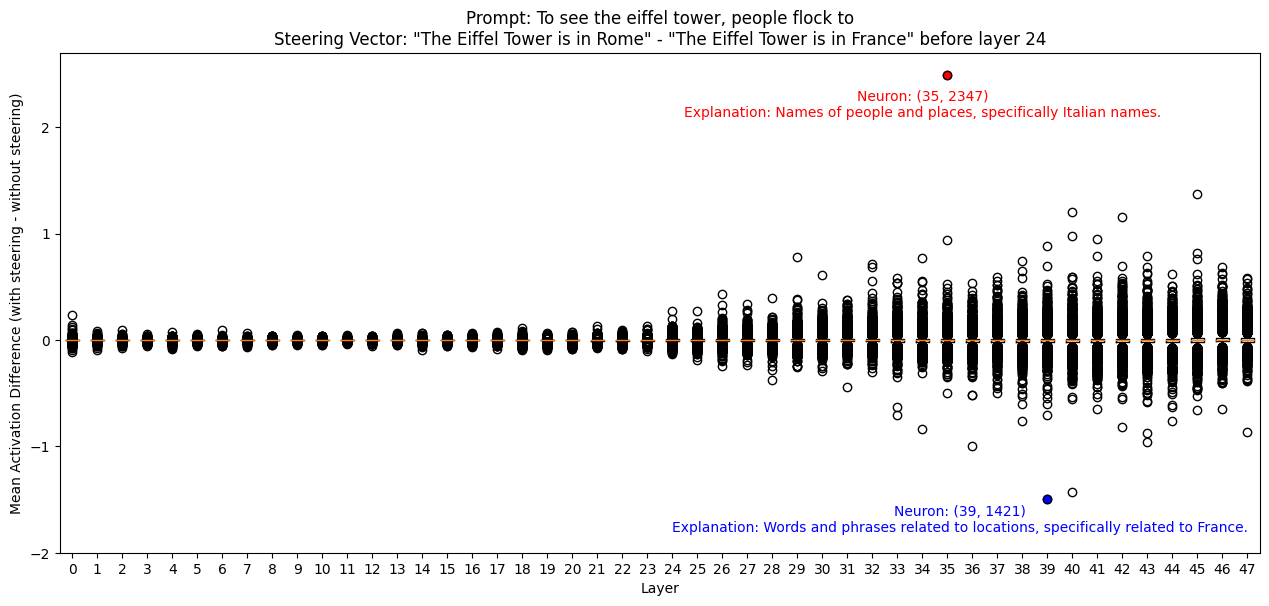

In [54]:
fig_name = FIGURE_PATH + "steering_act_diff_dist_" + prefix + ".pdf"
fig = plt.figure(figsize =(12, 5))
ax = fig.add_axes([0, 0, 1, 1])
plt.scatter(35 + 1, activation_diff_mean[35, 2347], color = "red")
plt.scatter(39 + 1, activation_diff_mean[39, 1421], color = "blue")
bp = ax.boxplot(pd.DataFrame(activation_diff_mean.T))
plt.annotate("Neuron: (35, 2347)\nExplanation: Names of people and places, specifically Italian names.",
    (35, 2.5 - 0.4), ha='center', color="red")
plt.annotate("Neuron: (39, 1421)\nExplanation: Words and phrases related to locations, specifically related to France.",
    (39 - 2.5, -1.5 - 0.3), ha='center', color="blue")
plt.ylim(-2, 2.7)
ax.set_xticklabels(list(range(48)))
ax.set_xlabel('Layer')
ax.set_ylabel('Mean Activation Difference (with steering - without steering)')
plt.title(prompt_specs, fontsize=12)
plt.savefig(fig_name, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# list activation difference for all neurons
# ordered by the largest (positive) to smallest (negative)
activation_diff_ordered_index = np.dstack(np.unravel_index(np.argsort(activation_diff_mean, axis=None)[::-1], activation_diff_mean.shape))[0,:,:]
activation_diff_ordered_index

array([[  35, 2347],
       [  45, 4702],
       [  40, 5750],
       ...,
       [  36,  300],
       [  40, 1921],
       [  39, 1421]])

In [ ]:
print_openai_explanaions_from_ordered_index(activation_diff_ordered_index)

------ Top positive related neurons ------
neuron_id: (35, 2347), explanations:  names of people and places, specifically Italian names.
neuron_id: (45, 4702), explanations:  geographical locations and related terms.
neuron_id: (40, 5750), explanations:  nouns and phrases related to specific geographic locations or significance.
neuron_id: (42, 2606), explanations:  words and phrases related to geographical locations and travel.
neuron_id: (40, 250), explanations:  years, dates, and durations related to historical events or reigns.
neuron_id: (41, 5427), explanations: locations and structures within historical contexts.
neuron_id: (35, 1327), explanations:  historical topics and references.
neuron_id: (39, 4923), explanations:  mixed letter and digit sequences within words.
neuron_id: (45, 3510), explanations:  historical context and references.
neuron_id: (43, 2521), explanations:  words and phrases related to religious and cultural aspects.
neuron_id: (41, 2844), explanations:  words

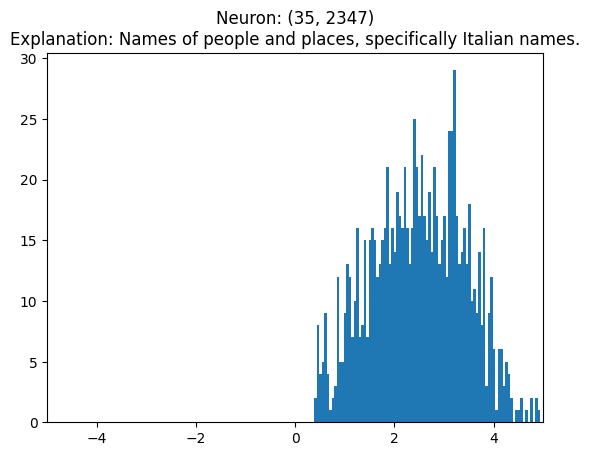

In [ ]:
fig_name = FIGURE_PATH + "neuron_hist_italian.pdf"
fig_title = "Neuron: (35, 2347)\nExplanation: Names of people and places, specifically Italian names."
plt.hist(activation_diff_iterations[:,35,2347], bins=100)
ax.set_xlabel('Activation Difference')
ax.set_ylabel('Count')
plt.xlim(-5, 5)
plt.title(fig_title)
plt.savefig(fig_name, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
np.average(activation_diff_iterations[:,35,2347])

2.4905122238993647

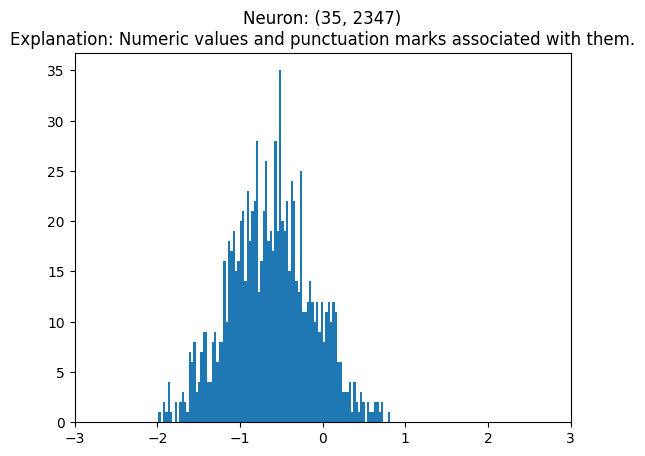

In [ ]:
fig_name = FIGURE_PATH + "neuron_hist_numeric.pdf"
fig_title = "Neuron: (35, 2347)\nExplanation: Numeric values and punctuation marks associated with them."
plt.hist(activation_diff_iterations[:,33,674], bins=100)
ax.set_xlabel('Activation Difference')
ax.set_ylabel('Count')
plt.xlim(-3, 3)
plt.title(fig_title)
plt.savefig(fig_name, format="pdf", bbox_inches="tight")
plt.show()

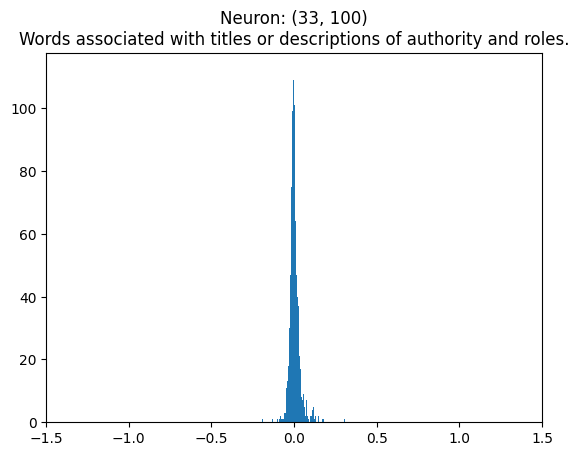

In [ ]:
fig_name = FIGURE_PATH + "neuron_hist_random.pdf"
fig_title = "Neuron: (33, 100)\nWords associated with titles or descriptions of authority and roles."
plt.hist(activation_diff_iterations[:,33,100], bins=100)
ax.set_xlabel('Activation Difference')
ax.set_ylabel('Count')
plt.xlim(-1.5, 1.5)
plt.title(fig_title)
plt.savefig(fig_name, format="pdf", bbox_inches="tight")
plt.show()

## My impression of this product is

In [ ]:
prompt = "My impression of this product is"

activation_additions = [
    *get_x_vector(
        prompt1="I love this product",
        prompt2="I hate this product",
        coeff=10,
        act_name=24,
        pad_method="tokens_right",
        model=model,
        custom_pad_id=model.to_single_token(" "),
    )
]

activation_diff_iterations = get_activation_diff_iterations(
    prompt,
    activation_additions,
    N_iterations=1000,
    tokens_to_generate=50,
    prompt_only=False)

prompt1="I love this product"
prompt2="I hate this product"
coeff=10
act_name=24
N_iterations=1000
tokens_to_generate=50
prompt_only=False
filename = "activation_diff_iterations.{}.{}.{}.{}.{}.{}.{}.{}.joblib".format(
    prompt,prompt1,prompt2,coeff,act_name,N_iterations,tokens_to_generate,prompt_only
)
parent_path = '/content/drive/MyDrive/CSE_256_Project/data/activation_diff_iterations/'
joblib.dump(activation_diff_iterations, parent_path + filename)

['/content/drive/MyDrive/CSE_256_Project/data/activation_diff_iterations/activation_diff_iterations.My impression of this product is.I love this product.I hate this product.10.24.1000.50.False.joblib']

In [40]:
filename = "activation_diff_iterations.My impression of this product is.I love this product.I hate this product.10.24.1000.50.False.joblib"
activation_diff_iterations = joblib.load(PARENT_PATH + filename)
activation_diff_iterations.shape

(1000, 48, 6400)

In [41]:
prefix = "product"
prompt_specs = "Prompt: My impression of this product is\n" + \
    'Steering Vector: "I love this product" - "I hate this product" before layer 24'

In [42]:
# average activation difference over 1000 randomly generated samples
activation_diff_mean = np.average(activation_diff_iterations, axis=0)

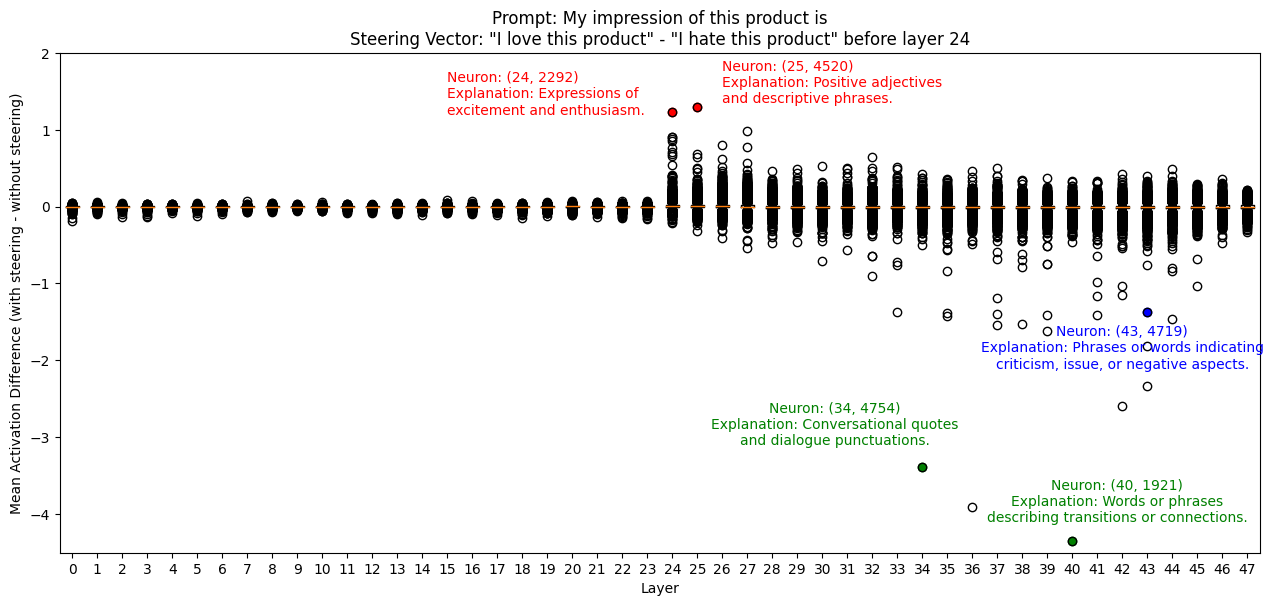

In [44]:
fig_name = FIGURE_PATH + "steering_act_diff_dist_" + prefix + ".pdf"
fig = plt.figure(figsize =(12, 5))
ax = fig.add_axes([0, 0, 1, 1])
plt.scatter(25 + 1, activation_diff_mean[25, 4520], color = "red")
plt.scatter(24 + 1, activation_diff_mean[24, 2292], color = "red")
plt.scatter(43 + 1, activation_diff_mean[43, 4719], color = "blue")
plt.scatter(40 + 1, activation_diff_mean[40, 1921], color = "green")
plt.scatter(34 + 1, activation_diff_mean[34, 4754], color = "green")
bp = ax.boxplot(pd.DataFrame(activation_diff_mean.T))
plt.annotate("Neuron: (25, 4520)\nExplanation: Positive adjectives\nand descriptive phrases.",
    (25 + 2, 1.35), color="red")
plt.annotate("Neuron: (24, 2292)\nExplanation: Expressions of\nexcitement and enthusiasm.",
    (24 - 8, 1.2), color="red")
plt.annotate("Neuron: (43, 4719)\nExplanation: Phrases or words indicating\ncriticism, issue, or negative aspects.",
    (43 , -1.5 - 0.6), ha='center', color="blue")
plt.annotate("Neuron: (40, 1921)\nExplanation: Words or phrases\ndescribing transitions or connections.",
    (40 + 2.8 , -4.1), ha='center', color="green")
plt.annotate("Neuron: (34, 4754)\nExplanation: Conversational quotes\nand dialogue punctuations.",
    (34 - 2.5 , -3.1), ha='center', color="green")
plt.ylim(-4.5, 2)
ax.set_xticklabels(list(range(48)))
ax.set_xlabel('Layer')
ax.set_ylabel('Mean Activation Difference (with steering - without steering)')
plt.title(prompt_specs, fontsize=12)
plt.savefig(fig_name, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# list activation difference for all neurons
# ordered by the largest (positive) to smallest (negative)
activation_diff_ordered_index = np.dstack(np.unravel_index(np.argsort(activation_diff_mean, axis=None)[::-1], activation_diff_mean.shape))[0,:,:]
activation_diff_ordered_index

array([[  25, 4520],
       [  24, 2292],
       [  27, 3298],
       ...,
       [  34, 4754],
       [  36,  300],
       [  40, 1921]])

In [ ]:
print_openai_explanaions_from_ordered_index(activation_diff_ordered_index)

------ Top positive related neurons ------
neuron_id: (25, 4520), explanations:  positive adjectives and descriptive phrases.
neuron_id: (24, 2292), explanations:  expressions of excitement and enthusiasm.
neuron_id: (27, 3298), explanations:  sequences of words related to personal actions and experiences.
neuron_id: (24, 2516), explanations:  expressions of evaluation or judgment.
neuron_id: (24, 5110), explanations:  words and phrases describing low and decreasing quantities.
neuron_id: (24, 5224), explanations: connecting words and phrases, as well as adjectives describing quantity or degree.
neuron_id: (24, 4142), explanations: words and phrases related to ease, comfort, and performance.
neuron_id: (26, 1929), explanations:  numeric values and related context.
neuron_id: (27, 6121), explanations:  sequences of connected or related words and phrases.
neuron_id: (24, 2690), explanations:  acronyms and abbreviations.
neuron_id: (24, 2567), explanations:  phrases indicating time and pr

## This new novel by the author is full of

In [ ]:
prompt = "This new novel by the author is full of"

activation_additions = [
    *get_x_vector(
        prompt1="despicable, atrocious content",
        prompt2="delightful, exciting content",
        coeff=10,
        act_name=24,
        **default_x_vector_kwargs
    )
]

activation_diff_iterations = get_activation_diff_iterations(
    prompt,
    activation_additions,
    N_iterations=1000,
    tokens_to_generate=50,
    prompt_only=False)

prompt1="despicable, atrocious content"
prompt2="delightful, exciting content"
coeff=10
act_name=24
N_iterations=1000
tokens_to_generate=50
prompt_only=False
filename = "activation_diff_iterations.{}.{}.{}.{}.{}.{}.{}.{}.joblib".format(
    prompt,prompt1,prompt2,coeff,act_name,N_iterations,tokens_to_generate,prompt_only
)
parent_path = '/content/drive/MyDrive/CSE_256_Project/data/activation_diff_iterations/'
joblib.dump(activation_diff_iterations, parent_path + filename)

['/content/drive/MyDrive/CSE_256_Project/data/activation_diff_iterations/activation_diff_iterations.This new novel by the author is full of.despicable, atrocious content.delightful, exciting content.10.24.1000.50.False.joblib']

In [45]:
filename = "activation_diff_iterations.This new novel by the author is full of.despicable, atrocious content.delightful, exciting content.10.24.1000.50.False.joblib"
activation_diff_iterations = joblib.load(PARENT_PATH + filename)
activation_diff_iterations.shape

(1000, 48, 6400)

In [46]:
prefix = "novel"
prompt_specs = "Prompt: This new novel by the author is full of\n" + \
    'Steering Vector: "despicable, atrocious content" - "delightful, exciting content"  before layer 24'

In [47]:
# average activation difference over 1000 randomly generated samples
activation_diff_mean = np.average(activation_diff_iterations, axis=0)

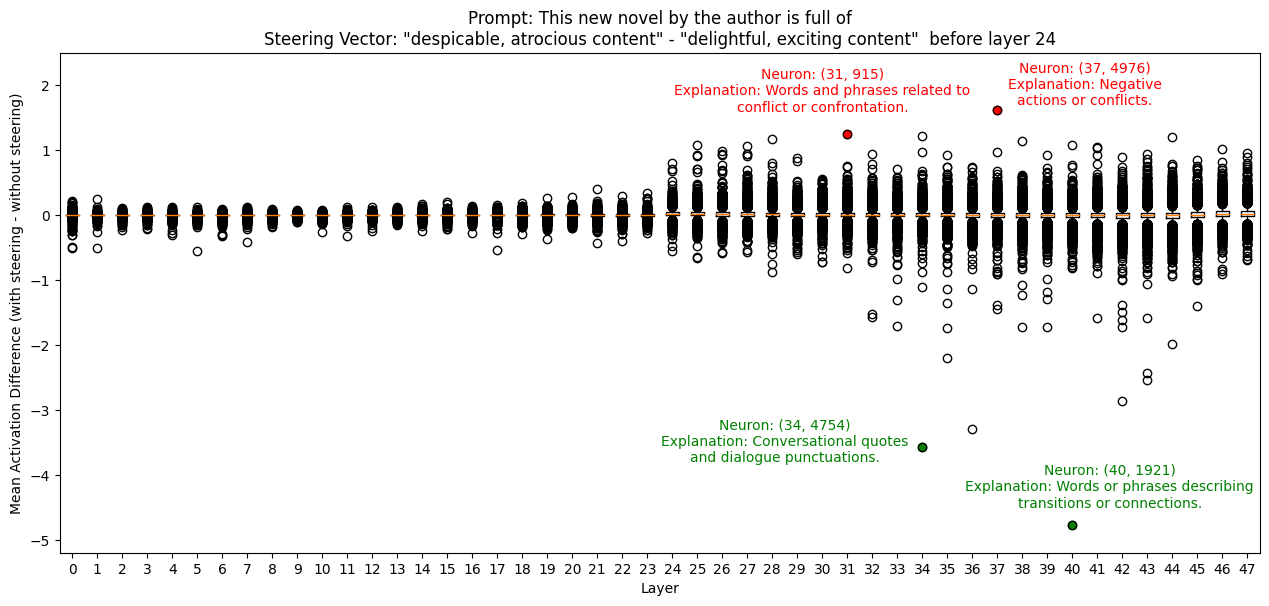

In [48]:
fig_name = FIGURE_PATH + "steering_act_diff_dist_" + prefix + ".pdf"
fig = plt.figure(figsize =(12, 5))
ax = fig.add_axes([0, 0, 1, 1])
plt.scatter(37 + 1, activation_diff_mean[37, 4976], color = "red")
plt.scatter(31 + 1, activation_diff_mean[31, 915], color = "red")
plt.scatter(40 + 1, activation_diff_mean[40, 1921], color = "green")
plt.scatter(34 + 1, activation_diff_mean[34, 4754], color = "green")
bp = ax.boxplot(pd.DataFrame(activation_diff_mean.T))
plt.annotate("Neuron: (37, 4976)\nExplanation: Negative\nactions or conflicts.",
    (37 + 4.5, 1.7), ha='center', color="red")
plt.annotate("Neuron: (31, 915)\nExplanation: Words and phrases related to\nconflict or confrontation.",
    (31, 1.6), ha='center', color="red")
plt.annotate("Neuron: (40, 1921)\nExplanation: Words or phrases describing\ntransitions or connections.",
    (40 + 2.5, -4.5), ha='center', color="green")
plt.annotate("Neuron: (34, 4754)\nExplanation: Conversational quotes\nand dialogue punctuations.",
    (34 - 4.5, -3.8), ha='center', color="green")
plt.ylim(-5.2, 2.5)
ax.set_xticklabels(list(range(48)))
ax.set_xlabel('Layer')
ax.set_ylabel('Mean Activation Difference (with steering - without steering)')
plt.title(prompt_specs, fontsize=12)
plt.savefig(fig_name, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# list activation difference for all neurons
# ordered by the largest (positive) to smallest (negative)
activation_diff_ordered_index = np.dstack(np.unravel_index(np.argsort(activation_diff_mean, axis=None)[::-1], activation_diff_mean.shape))[0,:,:]
activation_diff_ordered_index

array([[  37, 4976],
       [  31,  915],
       [  34,  902],
       ...,
       [  36,  300],
       [  34, 4754],
       [  40, 1921]])

In [ ]:
print_openai_explanaions_from_ordered_index(activation_diff_ordered_index)

------ Top positive related neurons ------
neuron_id: (37, 4976), explanations: negative actions or conflicts.
neuron_id: (31, 915), explanations:  words and phrases related to conflict or confrontation.
neuron_id: (34, 902), explanations: words and phrases related to extremism, political motivations, and derogatory terms.
neuron_id: (44, 1851), explanations: words related to conflicts, disputes, and negative incidents.
neuron_id: (28, 4729), explanations:  words and phrases related to social and political issues.
neuron_id: (38, 420), explanations:  words and phrases related to political events and conflicts.
neuron_id: (40, 2806), explanations: names of publications, magazines, or media outlets.
neuron_id: (25, 5555), explanations:  words related to ethical and legal issues.
neuron_id: (27, 581), explanations:  phrases indicating contrasts or comparisons.
neuron_id: (41, 2866), explanations:  specific product names and related numbers.
neuron_id: (41, 542), explanations:  words and p

## My relationship with my ex-husband was

In [ ]:
filename = "activation_diff_iterations.My relationship with my ex-husband was.Warm, intimate, caring, grateful.Hateful, bitter, gross, vile.10.10.1000.50.False.joblib"
activation_diff_iterations = joblib.load(PARENT_PATH + filename)
activation_diff_iterations.shape

(1000, 48, 6400)

In [ ]:
prefix = "relationship"
prompt_specs = 'Prompt: My relationship with my ex-husband was\n' + \
    'Steering Vector: "Warm, intimate, caring, grateful - Hateful, bitter, gross, vile" before layer 10'

In [ ]:
# average activation difference over 1000 randomly generated samples
activation_diff_mean = np.average(activation_diff_iterations, axis=0)

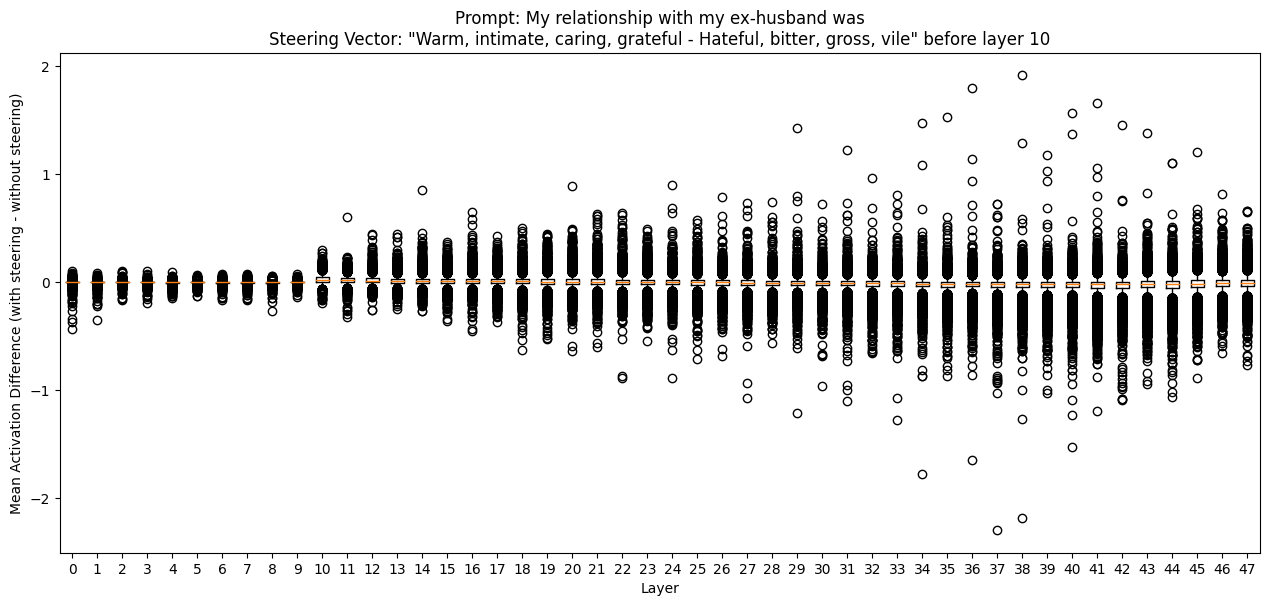

In [ ]:
fig_name = FIGURE_PATH + "steering_act_diff_dist_" + prefix + ".pdf"
fig = plt.figure(figsize =(12, 5))
ax = fig.add_axes([0, 0, 1, 1])
# plt.scatter(35 + 1, activation_diff_mean[35, 2347], color = "red")
# plt.scatter(39 + 1, activation_diff_mean[39, 1421], color = "blue")
bp = ax.boxplot(pd.DataFrame(activation_diff_mean.T))
# plt.annotate("Neuron: (35, 2347)\nExplanation: Names of people and places, specifically Italian names.",
#     (35, 2.5 - 0.4), ha='center', color="red")
# plt.annotate("Neuron: (39, 1421)\nExplanation: Words and phrases related to locations, specifically related to France.",
#     (39 - 2.5, -1.5 - 0.3), ha='center', color="blue")
# plt.ylim(-2, 2.7)
ax.set_xticklabels(list(range(48)))
ax.set_xlabel('Layer')
ax.set_ylabel('Mean Activation Difference (with steering - without steering)')
plt.title(prompt_specs)
plt.savefig(fig_name, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# list activation difference for all neurons
# ordered by the largest (positive) to smallest (negative)
activation_diff_ordered_index = np.dstack(np.unravel_index(np.argsort(activation_diff_mean, axis=None)[::-1], activation_diff_mean.shape))[0,:,:]
activation_diff_ordered_index

array([[  38, 4420],
       [  36,  300],
       [  41, 5736],
       ...,
       [  34, 1369],
       [  38, 6054],
       [  37, 3269]])

In [ ]:
print_openai_explanaions_from_ordered_index(activation_diff_ordered_index)

------ Top positive related neurons ------
neuron_id: (38, 4420), explanations:  punctuation marks and words with a moderate activation level.
neuron_id: (36, 300), explanations:  the ending punctuation of sentences or dialogue, as well as the spaces and line breaks surrounding them.
neuron_id: (41, 5736), explanations:  quotation marks and emphasizes text.
neuron_id: (40, 132), explanations:  noun phrases and compound words, often related to locations, tasks, and elements within a context.
neuron_id: (35, 5334), explanations:  conjunctions and related punctuation.
neuron_id: (34, 5698), explanations:  phrases and punctuations related to dialogues or quotations.
neuron_id: (42, 4079), explanations:  numbers and, to a lesser extent, possessive pronouns.
neuron_id: (29, 6265), explanations:  phrases showing relationships or comparisons between items, concepts or actions.
neuron_id: (43, 3384), explanations: conjunctions and punctuation marks that are related to listing or connecting phra

## I think you're


In [ ]:
filename = "activation_diff_iterations.I think you're.Anger.Calm.10.20.1000.50.False.joblib"
activation_diff_iterations = joblib.load(PARENT_PATH + filename)
activation_diff_iterations.shape

(1000, 48, 6400)

In [ ]:
prefix = "anger"
prompt_specs = "Prompt: I think you're, " + \
    'Steering Vector: "Anger" - "Calm" before layer 20'

In [ ]:
# average activation difference over 1000 randomly generated samples
activation_diff_mean = np.average(activation_diff_iterations, axis=0)

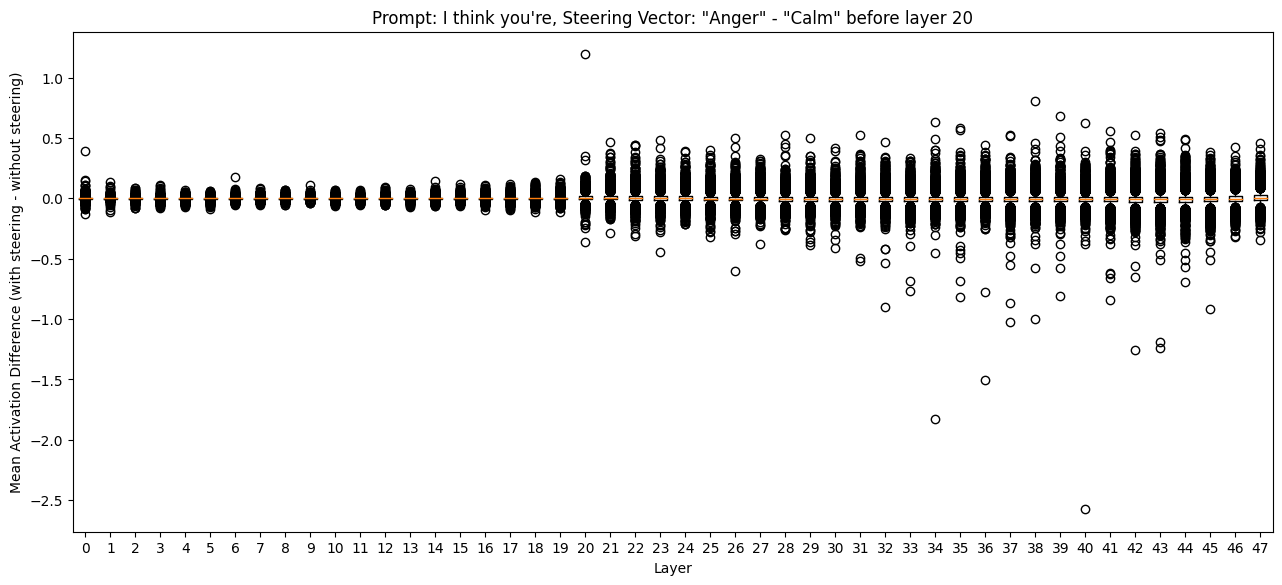

In [ ]:
fig_name = FIGURE_PATH + "steering_act_diff_dist_" + prefix + ".pdf"
fig = plt.figure(figsize =(12, 5))
ax = fig.add_axes([0, 0, 1, 1])
# plt.scatter(35 + 1, activation_diff_mean[35, 2347], color = "red")
# plt.scatter(39 + 1, activation_diff_mean[39, 1421], color = "blue")
bp = ax.boxplot(pd.DataFrame(activation_diff_mean.T))
# plt.annotate("Neuron: (35, 2347)\nExplanation: Names of people and places, specifically Italian names.",
#     (35, 2.5 - 0.4), ha='center', color="red")
# plt.annotate("Neuron: (39, 1421)\nExplanation: Words and phrases related to locations, specifically related to France.",
#     (39 - 2.5, -1.5 - 0.3), ha='center', color="blue")
# plt.ylim(-2, 2.7)
ax.set_xticklabels(list(range(48)))
ax.set_xlabel('Layer')
ax.set_ylabel('Mean Activation Difference (with steering - without steering)')
plt.title(prompt_specs)
plt.savefig(fig_name, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# list activation difference for all neurons
# ordered by the largest (positive) to smallest (negative)
activation_diff_ordered_index = np.dstack(np.unravel_index(np.argsort(activation_diff_mean, axis=None)[::-1], activation_diff_mean.shape))[0,:,:]
activation_diff_ordered_index

array([[  20, 2931],
       [  38,  798],
       [  39, 5422],
       ...,
       [  36,  300],
       [  34, 4754],
       [  40, 1921]])

In [ ]:
print_openai_explanaions_from_ordered_index(activation_diff_ordered_index)

------ Top positive related neurons ------
neuron_id: (20, 2931), explanations:  sequences of numbers and related terms.
neuron_id: (38, 798), explanations: personal pronouns and associated descriptions or actions.
neuron_id: (39, 5422), explanations:  words and phrases related to negativity or conflict.
neuron_id: (34, 734), explanations:  phrases related to strong negative emotions or critical opinions.
neuron_id: (40, 2806), explanations: names of publications, magazines, or media outlets.
neuron_id: (35, 236), explanations:  expressions related to opposition, conflict, or disagreement.
neuron_id: (35, 4951), explanations: intense and aggressive emotional language.
neuron_id: (41, 657), explanations: academic or research-related terms and positions.
neuron_id: (43, 4517), explanations:  instances of comparison or contrast between subjects.
neuron_id: (37, 6197), explanations:  names of people and related descriptors.
neuron_id: (31, 1556), explanations: censored or partially censore

## I want to kill you

In [ ]:
filename = "activation_diff_iterations.I want to kill you because you're such a.Intent to convert you to Christianity.Intent to hurt you.10.10.1000.50.False.joblib"
activation_diff_iterations = joblib.load(PARENT_PATH + filename)
activation_diff_iterations.shape

(1000, 48, 6400)

In [ ]:
prefix = "anger"
prompt_specs = "Prompt: I want to kill you because you're such a\n" + \
    'Steering Vector: "Intent to convert you to Christianity" - "Intent to hurt you" before layer 20'

In [ ]:
# average activation difference over 1000 randomly generated samples
activation_diff_mean = np.average(activation_diff_iterations, axis=0)

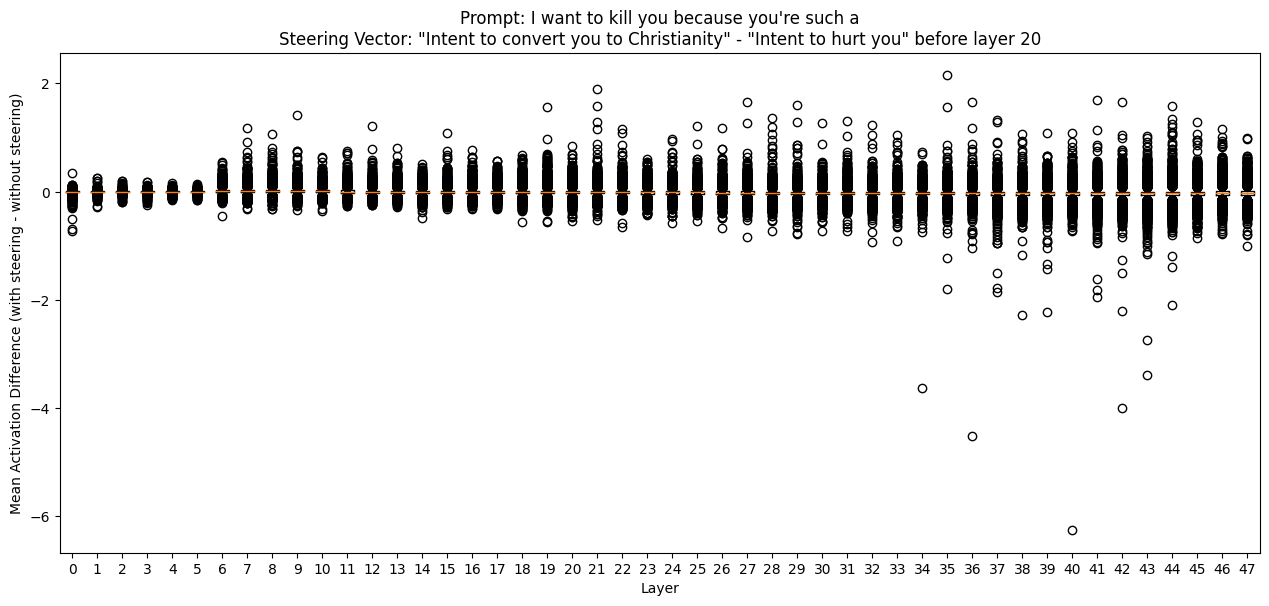

In [ ]:
fig_name = FIGURE_PATH + "steering_act_diff_dist_" + prefix + ".pdf"
fig = plt.figure(figsize =(12, 5))
ax = fig.add_axes([0, 0, 1, 1])
# plt.scatter(35 + 1, activation_diff_mean[35, 2347], color = "red")
# plt.scatter(39 + 1, activation_diff_mean[39, 1421], color = "blue")
bp = ax.boxplot(pd.DataFrame(activation_diff_mean.T))
# plt.annotate("Neuron: (35, 2347)\nExplanation: Names of people and places, specifically Italian names.",
#     (35, 2.5 - 0.4), ha='center', color="red")
# plt.annotate("Neuron: (39, 1421)\nExplanation: Words and phrases related to locations, specifically related to France.",
#     (39 - 2.5, -1.5 - 0.3), ha='center', color="blue")
# plt.ylim(-2, 2.7)
ax.set_xticklabels(list(range(48)))
ax.set_xlabel('Layer')
ax.set_ylabel('Mean Activation Difference (with steering - without steering)')
plt.title(prompt_specs)
plt.savefig(fig_name, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# list activation difference for all neurons
# ordered by the largest (positive) to smallest (negative)
activation_diff_ordered_index = np.dstack(np.unravel_index(np.argsort(activation_diff_mean, axis=None)[::-1], activation_diff_mean.shape))[0,:,:]
activation_diff_ordered_index

array([[  35, 5334],
       [  21,   97],
       [  41, 5736],
       ...,
       [  42, 3117],
       [  36,  300],
       [  40, 1921]])

In [ ]:
print_openai_explanaions_from_ordered_index(activation_diff_ordered_index)

------ Top positive related neurons ------
neuron_id: (35, 5334), explanations:  conjunctions and related punctuation.
neuron_id: (21, 97), explanations:  phrases related to completing or achieving tasks.
neuron_id: (41, 5736), explanations:  quotation marks and emphasizes text.
neuron_id: (36, 3506), explanations:  names of sports and various forms of gaming.
neuron_id: (42, 4079), explanations:  numbers and, to a lesser extent, possessive pronouns.
neuron_id: (27, 6018), explanations:  words related to activity and action.
neuron_id: (29, 5130), explanations:  words related to numerical values with a focus on ranges or connections.
neuron_id: (21, 1691), explanations: contractions, specific capitalization, and punctuation marks.
neuron_id: (44, 1274), explanations:  numbers or numerical representation in parentheses or related to a list format.
neuron_id: (35, 3257), explanations:  parts of sentences and phrases that indicate emphasis or a specific statement.
neuron_id: (19, 110), ex

# Plot clusters of explanations using embeddings

In [ ]:
PARENT_PATH = "/content/drive/MyDrive/CSE_256_Project/data/activation_diff_iterations/"
FIGURE_PATH = "/content/drive/MyDrive/CSE_256_Project/figure/"

## Eiffel Tower is in Rome

In [ ]:
filename = "activation_diff_iterations.To see the eiffel tower.Rome.France.10.24.1000.50.False.joblib"
activation_diff_iterations = joblib.load(PARENT_PATH + filename)
activation_diff_mean = np.average(activation_diff_iterations, axis=0)
activation_diff_ordered_index = np.dstack(np.unravel_index(np.argsort(activation_diff_mean, axis=None)[::-1], activation_diff_mean.shape))[0,:,:]
neuron_explanations = store_openai_explanaions_from_ordered_index(
    activation_diff_ordered_index,
    neuron_store_size = 100)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

neuron_store_id_list = neuron_explanations["positive"]["ids"][0:50] + neuron_explanations["negative"]["ids"][0:50]
neuron_store_explanation_list = neuron_explanations["positive"]["explanations"][0:50] + neuron_explanations["negative"]["explanations"][0:50]
embeddings = model_sentence.encode(neuron_store_explanation_list)

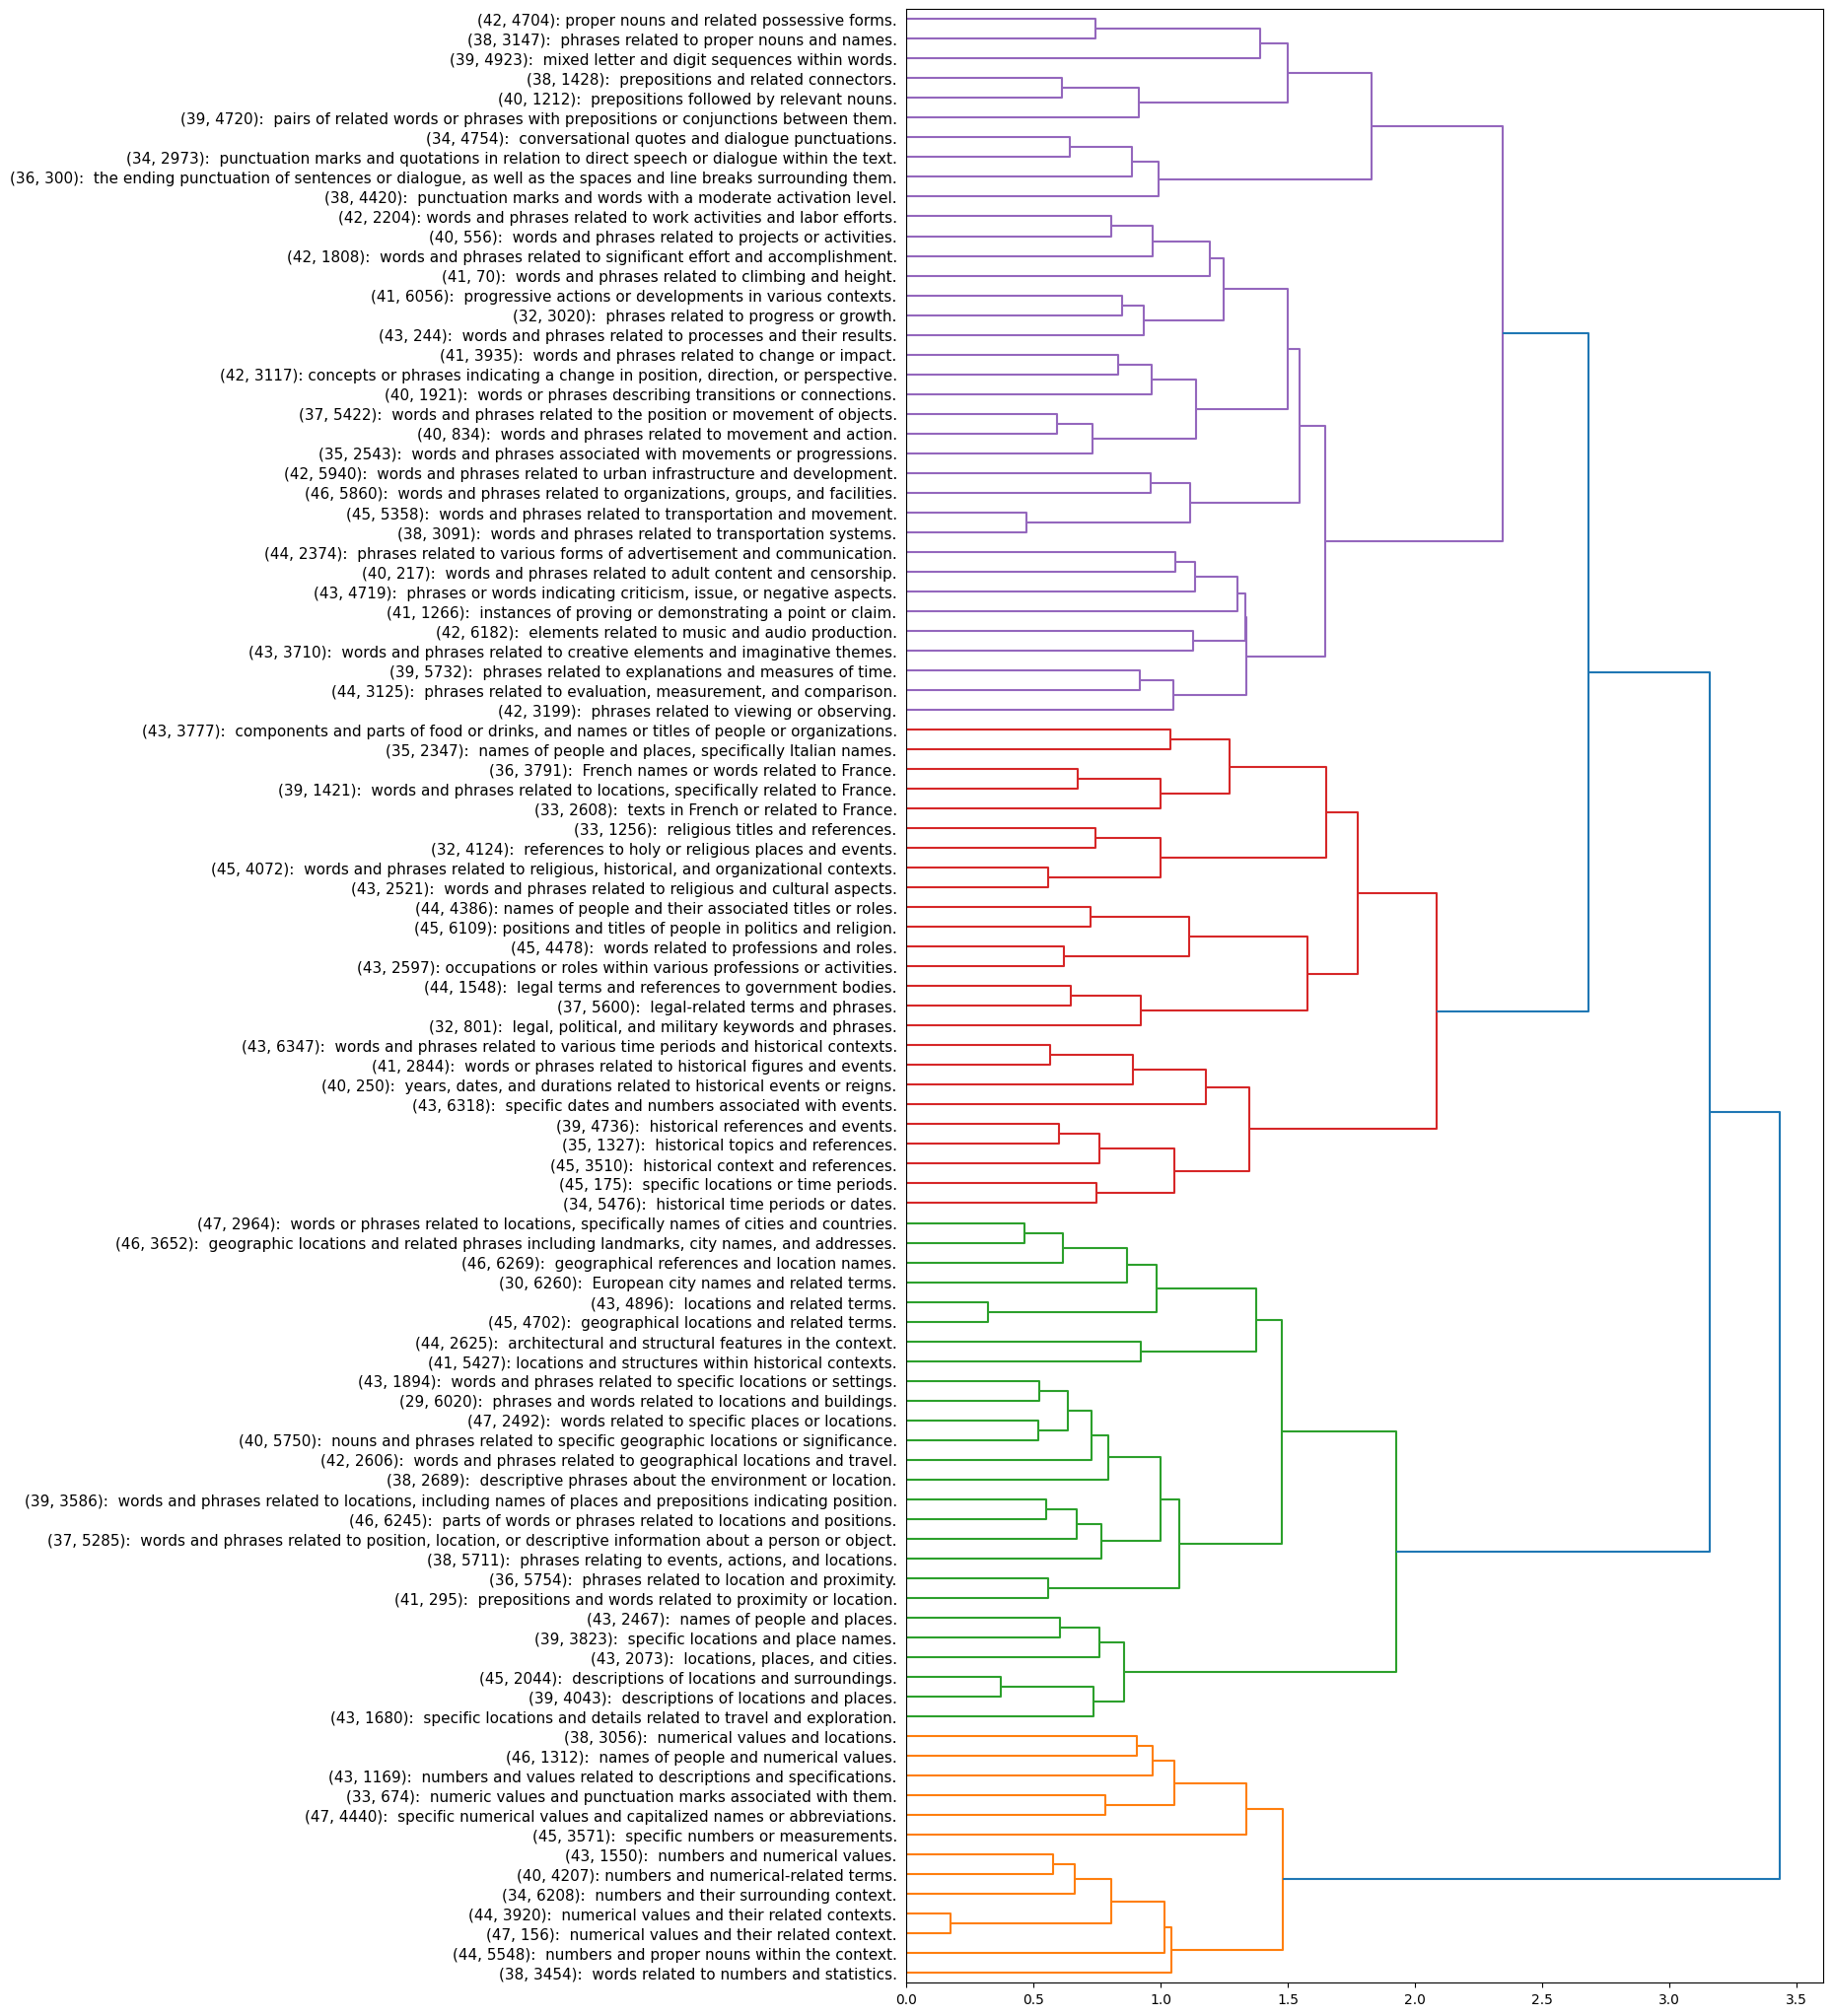

In [ ]:
fig_name = FIGURE_PATH + "agglomerative_clustering_eiffel.pdf"
plt.figure(figsize=(12, 26))
neuron_labels = [str(x[0]) + ": " + x[1]
                 for x in zip(neuron_store_id_list, neuron_store_explanation_list)]
dendrogram = sch.dendrogram(sch.linkage(embeddings, method='ward'),
                            orientation='right',
                            labels=neuron_labels,
                            leaf_font_size=11)
plt.savefig(fig_name, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
neuron_explanations = store_openai_explanaions_from_ordered_index(
    activation_diff_ordered_index,
    neuron_store_size = 1000)

In [ ]:
# Perform clustering
neuron_store_id_list = neuron_explanations["positive"]["ids"] + neuron_explanations["negative"]["ids"]
neuron_store_explanation_list = neuron_explanations["positive"]["explanations"] + neuron_explanations["negative"]["explanations"]
embeddings = model_sentence.encode(neuron_store_explanation_list)

num_clusters = 10
clustering_model = AgglomerativeClustering(n_clusters=num_clusters,
                                           affinity='euclidean',
                                           linkage='ward')
# clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(
        str(neuron_store_id_list[sentence_id]) + ": " + \
        neuron_store_explanation_list[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1, ": size ", len(clustered_sentences[i]))
    print(cluster)
    print("")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Cluster  1 : size  271
['(29, 6020):  phrases and words related to locations and buildings.', '(42, 3199):  phrases related to viewing or observing.', '(44, 2625):  architectural and structural features in the context.', '(37, 5285):  words and phrases related to position, location, or descriptive information about a person or object.', '(42, 4704): proper nouns and related possessive forms.', '(42, 5940):  words and phrases related to urban infrastructure and development.', '(33, 578):  words and phrases related to foreign languages and names.', '(41, 4033):  nouns and verbs related to technology and interactions with devices.', '(37, 2995): compound noun phrases or combinations of adjectives and nouns.', '(46, 160):  various forms of specialized or technical terminology.', '(40, 3110):  noun phrases and their adjectives or modifiers.', '(41, 1237): noun phrases related to groups or collections of things.', '(41, 3019):  words describing people or characters and their attributes or re

In [ ]:
from umap.umap_ import UMAP
import hdbscan
import matplotlib.pyplot as plt

umap_data = UMAP(n_neighbors=15,
                 n_components=2,
                 min_dist=0.0,
                 random_state = 0,
                 metric='euclidean',
                 target_metric='categorical').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster_assignment

In [ ]:
from sklearn.neighbors import NearestCentroid

clf = NearestCentroid()
clf.fit(embeddings, cluster_assignment)
centroids = clf.centroids_
centroid_index = [
    np.argmin(np.linalg.norm(embeddings - centroids[i], axis=1))
        for i in range(num_clusters)]
centroid_index

[1695, 993, 1588, 1103, 1139, 1051, 977, 1321, 334, 83]

In [ ]:
cluster_labels = []
for i, neuron_id in enumerate(centroid_index):
    cluster_labels.append("Cluster " + str(i) + " - Centroid neuron " + \
          str(neuron_store_id_list[neuron_id]) + ": " + \
          neuron_store_explanation_list[neuron_id] + \
          " Size " + str(len(clustered_sentences[i])))
cluster_labels

['Cluster 0 - Centroid neuron (46, 2661):  descriptive phrases related to locations, objects, and materials. Size 271',
 'Cluster 1 - Centroid neuron (40, 4515):  numbers and words related to numerical values. Size 217',
 'Cluster 2 - Centroid neuron (41, 851):  instances of punctuation, particularly quotation marks and periods. Size 123',
 'Cluster 3 - Centroid neuron (37, 4353):  words and phrases related to events and activities. Size 520',
 'Cluster 4 - Centroid neuron (42, 762):  location names and geographical references. Size 124',
 'Cluster 5 - Centroid neuron (45, 2142):  prepositions and their related phrases. Size 68',
 'Cluster 6 - Centroid neuron (34, 6074): words and phrases related to actions and processes. Size 125',
 'Cluster 7 - Centroid neuron (40, 6307):  numerical values and quantities within the context. Size 270',
 'Cluster 8 - Centroid neuron (31, 6072):  titles and names of people, places, and organizations. Size 106',
 'Cluster 9 - Centroid neuron (47, 1455): 

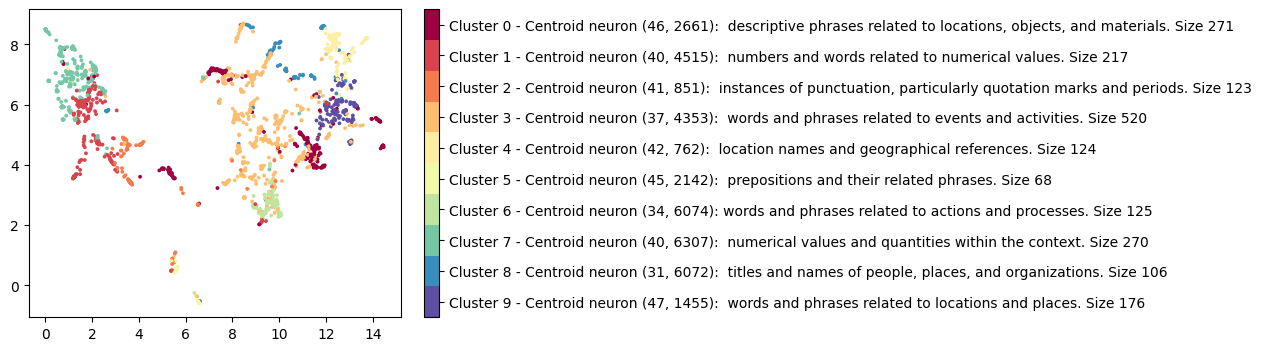

In [ ]:
# Visualize clusters
from matplotlib.colors import LinearSegmentedColormap

fig_name = FIGURE_PATH + "umap_eiffel.pdf"
cmap = plt.get_cmap('Spectral', num_clusters)
fig, ax = plt.subplots(figsize=(6, 4))
scatter = ax.scatter(result.x, result.y, c=result.labels,
                     cmap=cmap, s=3)
cbar = plt.colorbar(scatter)
# set ticks locations
tick_locs = (np.arange(num_clusters) + 0.5)*(num_clusters-1)/num_clusters
cbar.set_ticks(tick_locs)
# set tick labels
cbar.set_ticklabels(cluster_labels)
cbar.ax.invert_yaxis()
plt.savefig(fig_name, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
filename = "neuron_explanations_eiffel.joblib"
parent_path = '/content/drive/MyDrive/CSE_256_Project/data/'
joblib.dump(neuron_explanations, parent_path + filename)

['/content/drive/MyDrive/CSE_256_Project/data/neuron_explanations_eiffel.joblib']

# Plot distribution with and without steering

## My impression of this product is

In [ ]:
prompt = "My impression of this product is"

activation_additions = [
    *get_x_vector(
        prompt1="I love this product",
        prompt2="I hate this product",
        coeff=10,
        act_name=24,
        pad_method="tokens_right",
        model=model,
        custom_pad_id=model.to_single_token(" "),
    )
]

def get_activation_iterations_with_without_steering(
    prompt=prompt,
    activation_additions=activation_additions,
    N_iterations=100,
    tokens_to_generate=30,
    prompt_only=False):
    N_iterations = N_iterations
    n_layers = 48
    d_mlp = 6400
    # prompt_len = len(model.to_str_tokens(prompt))
    # token_len = prompt_len + tokens_to_generate
    dataframes_iterations = [[], []]
    # caches_shape = (N_iterations, token_len, n_layers, d_mlp)
    caches_shape = (N_iterations, n_layers, d_mlp)
    caches_iterations = [np.zeros(caches_shape), np.zeros(caches_shape)]

    for n in range(N_iterations):
        dataframes, caches = run_hooked_and_normal_with_cache_mlp(
            model = model,
            activation_additions = activation_additions,
            gen_args = dict(
                prompt_batch=[prompt] * 1,
                tokens_to_generate=tokens_to_generate,
                top_p=0.3,
                temperature=1.0,
                freq_penalty=1.0,
                seed=n
            )
        )
        dataframes_iterations[0].append(dataframes[0])
        dataframes_iterations[1].append(dataframes[1])
        for layer in range(n_layers):
            caches_iterations[0][n,layer,:] = np.average(to_numpy(caches[0][f'blocks.{layer}.mlp.hook_post'])[0,:,:], axis=0)
            caches_iterations[1][n,layer,:] = np.average(to_numpy(caches[1][f'blocks.{layer}.mlp.hook_post'])[0,:,:], axis=0)

    return dataframes_iterations, caches_iterations

dataframes_iterations, caches_iterations = get_activation_iterations_with_without_steering(
    prompt,
    activation_additions,
    N_iterations=100,
    tokens_to_generate=50,
    prompt_only=False)

prompt1="I love this product"
prompt2="I hate this product"
coeff=10
act_name=24
N_iterations=100
tokens_to_generate=50
prompt_only=False
filename = "activation_diff_iterations.{}.{}.{}.{}.{}.{}.{}.{}.joblib".format(
    prompt,prompt1,prompt2,coeff,act_name,N_iterations,tokens_to_generate,prompt_only
)
parent_path = '/content/drive/MyDrive/CSE_256_Project/data/activation_caches/'
joblib.dump((dataframes_iterations, caches_iterations),
            parent_path + filename)

In [ ]:
prompt = "My impression of this product is"

activation_additions = [
    *get_x_vector(
        prompt1="I love this product",
        prompt2="I hate this product",
        coeff=10,
        act_name=24,
        pad_method="tokens_right",
        model=model,
        custom_pad_id=model.to_single_token(" "),
    )
]

default_layer = 24
default_neuron_index = 2292

tokens_to_generate=50
prompt_only = False
N_iterations = 10
n_layers = 48
d_mlp = 6400
# prompt_len = len(model.to_str_tokens(prompt))
# token_len = prompt_len + tokens_to_generate
dataframes_iterations = [[], []]
# caches_shape = (N_iterations, token_len, n_layers, d_mlp)
# caches_shape = (N_iterations, n_layers, d_mlp)
caches_shape = (N_iterations)
caches_iterations = [np.zeros(caches_shape), np.zeros(caches_shape)]

for n in range(N_iterations):
    dataframes, caches = run_hooked_and_normal_with_cache_mlp(
        model = model,
        activation_additions = activation_additions,
        gen_args = dict(
            prompt_batch=[prompt] * 1,
            tokens_to_generate=tokens_to_generate,
            top_p=0.3,
            temperature=1.0,
            freq_penalty=1.0,
            seed=n
        )
    )
    dataframes_iterations[0].append(dataframes[0])
    dataframes_iterations[1].append(dataframes[1])
    caches_iterations[0][n] = np.average(to_numpy(caches[0][f'blocks.{default_layer}.mlp.hook_post'])[0,:,default_neuron_index], axis=0)
    caches_iterations[1][n] = np.average(to_numpy(caches[1][f'blocks.{default_layer}.mlp.hook_post'])[0,:,default_neuron_index], axis=0)


In [60]:
prompt = "To see the eiffel tower, people flock to"

activation_additions = [
    *get_x_vector(
        prompt1="The Eiffel Tower is in Rome",
        prompt2="The Eiffel Tower is in France",
        coeff=10,
        act_name=24,
        **default_x_vector_kwargs
    )
]

default_layer = 35
default_neuron_index = 2347

tokens_to_generate=50
prompt_only = False
N_iterations = 1000
n_layers = 48
d_mlp = 6400
# prompt_len = len(model.to_str_tokens(prompt))
# token_len = prompt_len + tokens_to_generate
dataframes_iterations = [[], []]
# caches_shape = (N_iterations, token_len, n_layers, d_mlp)
# caches_shape = (N_iterations, n_layers, d_mlp)
caches_shape = (N_iterations)
caches_iterations = [np.zeros(caches_shape), np.zeros(caches_shape)]

for n in range(N_iterations):
    dataframes, caches = run_hooked_and_normal_with_cache_mlp(
        model = model,
        activation_additions = activation_additions,
        gen_args = dict(
            prompt_batch=[prompt] * 1,
            tokens_to_generate=tokens_to_generate,
            top_p=0.3,
            temperature=1.0,
            freq_penalty=1.0,
            seed=n
        )
    )
    dataframes_iterations[0].append(dataframes[0]["prompts"][0] + dataframes[0]["completions"][0])
    dataframes_iterations[1].append(dataframes[1]["prompts"][0] + dataframes[1]["completions"][0])
    caches_iterations[0][n] = np.average(to_numpy(caches[0][f'blocks.{default_layer}.mlp.hook_post'])[0,:,default_neuron_index], axis=0)
    caches_iterations[1][n] = np.average(to_numpy(caches[1][f'blocks.{default_layer}.mlp.hook_post'])[0,:,default_neuron_index], axis=0)


In [59]:
dataframes[0]["prompts"][0] + dataframes[0]["completions"][0]

'My impression of this product is that it is very good. I use it as a dry shampoo and also for my hair to help with frizz. It does not dry out my hair and I love the way it feels on my scalp. The scent is very nice too! I'

In [ ]:
def get_neuron_acts(text, layer, neuron_index):
    # Hacky way to get out state from a single hook - we have a single element list and edit that list within the hook.
    cache = {}

    def caching_hook(act, hook):
        cache["activation"] = act[0, :, neuron_index]

    model.run_with_hooks(
        text, fwd_hooks=[(f"blocks.{layer}.mlp.hook_post", caching_hook)]
    )
    return to_numpy(cache["activation"])

In [ ]:
dataframes_iterations[0][0]["prompts"][0] + dataframes_iterations[0][0]["completions"][0]

'My impression of this product is that it\'s very good for a cheap, low-quality, no-name "light" flashlight. It\'s not bad at all for the price. I\'ve used it a few times and have had no problems with it. It\'s not waterproof'

In [ ]:
gpt2_text = dataframes_iterations[1][3]["prompts"][0] + dataframes_iterations[1][2]["completions"][0]
gpt2_tokens = model.to_tokens(gpt2_text)

print(model.to_str_tokens(gpt2_text))
print(get_neuron_acts(gpt2_text, default_layer, default_neuron_index))

['<|endoftext|>', 'My', ' impression', ' of', ' this', ' product', ' is', ' that', ' it', ' is', ' a', ' bit', ' more', ' expensive', ' than', ' the', ' "', 'traditional', '"', ' plastic', ' pipe', ' I', ' have', ' used', ' in', ' the', ' past', '.', ' It', "'s", ' also', ' a', ' bit', ' thicker', ' and', ' has', ' some', ' sort', ' of', ' rubber', 'ized', ' coating', ' on', ' it', '.', ' The', ' best', ' part', ' about', ' this', ' product', ' is', ' that', ' it', "'s", ' made', ' from']
[ 0.09830158 -0.14809565 -0.12940544 -0.11435046 -0.0958024  -0.08124678
 -0.04372871 -0.01332535 -0.02073938 -0.02007924 -0.0339222  -0.00128219
 -0.05769245 -0.08843747 -0.13231397 -0.14550409 -0.13937755 -0.16033103
 -0.16114265 -0.07151762  0.03779613 -0.06528261 -0.16603218 -0.12221118
 -0.14673702 -0.16372186 -0.05839543 -0.0840844  -0.16815631 -0.13355723
 -0.12365404 -0.16689825 -0.10636767 -0.16953929 -0.126498   -0.1599014
 -0.07232884 -0.13594107 -0.06676025 -0.08783401 -0.15028967 -0.13271

In [ ]:
# This is some CSS (tells us what style )to give each token a thin gray border, to make it easy to see token separation
style_string = """<style>
    span.token {
        border: 1px solid rgb(123, 123, 123)
        }
    </style>"""


def calculate_color(val, max_val, min_val):
    # Hacky code that takes in a value val in range [min_val, max_val], normalizes it to [0, 1] and returns a color which interpolates between slightly off-white and red (0 = white, 1 = red)
    # We return a string of the form "rgb(240, 240, 240)" which is a color CSS knows
    normalized_val = (val - min_val) / max_val
    return f"rgb(240, {240*(1-normalized_val)}, {240*(1-normalized_val)})"


def basic_neuron_vis(text, layer, neuron_index, max_val=None, min_val=None):
    """
    text: The text to visualize
    layer: The layer index
    neuron_index: The neuron index
    max_val: The top end of our activation range, defaults to the maximum activation
    min_val: The top end of our activation range, defaults to the minimum activation

    Returns a string of HTML that displays the text with each token colored according to its activation

    Note: It's useful to be able to input a fixed max_val and min_val, because otherwise the colors will change as you edit the text, which is annoying.
    """
    if layer is None:
        return "Please select a Layer"
    if neuron_index is None:
        return "Please select a Neuron"
    acts = get_neuron_acts(text, layer, neuron_index)
    act_max = acts.max()
    act_min = acts.min()
    # Defaults to the max and min of the activations
    if max_val is None:
        max_val = act_max
    if min_val is None:
        min_val = act_min
    # We want to make a list of HTML strings to concatenate into our final HTML string
    # We first add the style to make each token element have a nice border
    htmls = [style_string]
    # We then add some text to tell us what layer and neuron we're looking at - we're just dealing with strings and can use f-strings as normal
    # h4 means "small heading"
    htmls.append(f"<h4>Layer: <b>{layer}</b>. Neuron Index: <b>{neuron_index}</b></h4>")
    # We then add a line telling us the limits of our range
    htmls.append(
        f"<h4>Max Range: <b>{max_val:.4f}</b>. Min Range: <b>{min_val:.4f}</b></h4>"
    )
    # If we added a custom range, print a line telling us the range of our activations too.
    if act_max != max_val or act_min != min_val:
        htmls.append(
            f"<h4>Custom Range Set. Max Act: <b>{act_max:.4f}</b>. Min Act: <b>{act_min:.4f}</b></h4>"
        )
    # Convert the text to a list of tokens
    str_tokens = model.to_str_tokens(text)
    for tok, act in zip(str_tokens, acts):
        # A span is an HTML element that lets us style a part of a string (and remains on the same line by default)
        # We set the background color of the span to be the color we calculated from the activation
        # We set the contents of the span to be the token
        htmls.append(
            f"<span class='token' style='background-color:{calculate_color(act, max_val, min_val)}' >{tok}</span>"
        )

    return "".join(htmls)

In [37]:
from IPython.display import HTML

# The function outputs a string of HTML
default_max_val = 4.0
default_min_val = 0.0
default_html_string = basic_neuron_vis(
    gpt2_text,
    default_layer,
    default_neuron_index
)

# IPython lets us display HTML
print("Displayed HTML")
display(HTML(default_html_string))

# We can also print the string directly
print("HTML String - it's just raw HTML code!")
print(default_html_string)

Displayed HTML


HTML String - it's just raw HTML code!
<style> 
    span.token {
        border: 1px solid rgb(123, 123, 123)
        } 
    </style><h4>Layer: <b>24</b>. Neuron Index: <b>2292</b></h4><h4>Max Range: <b>0.9101</b>. Min Range: <b>-0.1700</b></h4><span class='token' style='background-color:rgb(240, 169.24089431762695, 169.24089431762695)' ><|endoftext|></span><span class='token' style='background-color:rgb(240, 234.21889141201973, 234.21889141201973)' >My</span><span class='token' style='background-color:rgb(240, 229.29005026817322, 229.29005026817322)' > impression</span><span class='token' style='background-color:rgb(240, 225.31986594200134, 225.31986594200134)' > of</span><span class='token' style='background-color:rgb(240, 220.42851269245148, 220.42851269245148)' > this</span><span class='token' style='background-color:rgb(240, 216.5900158882141, 216.5900158882141)' > product</span><span class='token' style='background-color:rgb(240, 206.6960370540619, 206.6960370540619)' > is</span>

In [1]:
plt.hist(caches_iterations[1], bins=100)
plt.show()

NameError: ignored

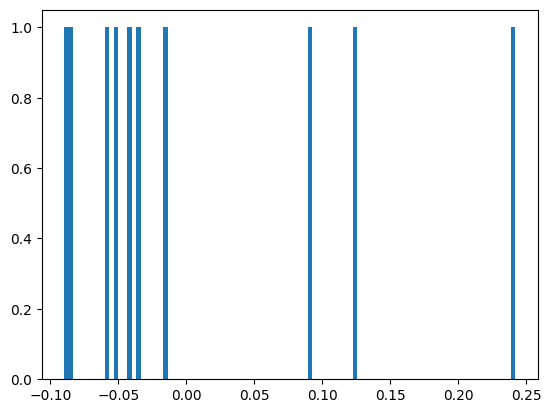

In [ ]:
plt.hist(caches_iterations[0], bins=100)
plt.show()